# Principal Patterns Paper Plots - Other Scenarios

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pypsa
import os
import sys
import geopandas
import tables
import matplotlib
from operator import itemgetter, attrgetter
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from sklearn.preprocessing import Normalizer

## Calculations

In [4]:
dic = '../data/'
filename = ["postnetwork-elec_only_0_0.05.h5",
            "postnetwork-elec_only_0.0625_0.05.h5",
            "postnetwork-elec_only_0.125_0.05.h5",
            "postnetwork-elec_only_0.25_0.05.h5",
            "postnetwork-elec_only_0.375_0.05.h5"]
filename_CO2 = ["postnetwork-elec_only_0.125_0.4.h5",
                "postnetwork-elec_only_0.125_0.3.h5",
                "postnetwork-elec_only_0.125_0.2.h5",
                "postnetwork-elec_only_0.125_0.1.h5",
                "postnetwork-elec_only_0.125_0.05.h5"]

In [22]:
PC1_con1,PC2_con1,PC3_con1,PC4_con1,PC5_con1,PC6_con1 = [np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),]
PC1_con2,PC2_con2,PC3_con2,PC4_con2,PC5_con2,PC6_con2 = [np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),]
PC1_con3,PC2_con3,PC3_con3,PC4_con3,PC5_con3,PC6_con3 = [np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),]
PC_con1 = []
PC_con2 = []
PC_con3 = []

for i in np.arange(0,len(filename)):
    network = pypsa.Network(dic+filename[i])
    data_names = network.loads_t.p.columns
    
    #%% Define index and columns
    time_index = network.loads_t.p_set.index 
    country_column = network.loads_t.p_set.columns
    
    #%% Calculating mismatch
    # Defining dispatched electricity generation
    generation = network.generators_t.p.groupby(network.generators.bus, axis=1).sum()
    # Defining load 
    load = network.loads_t.p_set
    # Calculate mismatch
    mismatch = generation - load # Using available electricity generation
    
    #%% Principal Component Analysis
    X = mismatch
    X_mean = np.mean(X,axis=0) # axis=0, mean at each colume 
    X_mean = np.array(X_mean.values).reshape(30,1) # Define as an array
    X_cent = np.subtract(X,X_mean.T)
    # Calculate normalization constant
    c = 1/np.sqrt(np.sum(np.mean(((X_cent.values)**2),axis=0)))
    # Normalize the centered data
    B = c*(X_cent.values)
    # Convariance of normalized and centered data
    C_new = np.dot(B.T,B)*1/(8760-1)
    C = np.cov(B.T,bias=True) 
    # Calculate eigen values and eigen vectors 
    eig_val, eig_vec = np.linalg.eig(C)
    # Calculate amplitude
    T = np.dot(B,eig_vec)
    
    ## PART 1 ##########################################
    ## Collecting mismatch contribution terms
    gen_grouped = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum().values
    mismatch_terms = pd.DataFrame({'wind': gen_grouped[:,0]+gen_grouped[:,1],
                                    'ror': gen_grouped[:,2],
                                    'solar': gen_grouped[:,3],
                                    'load': load.sum(axis=1).values},index=time_index)
    # Collecting technologies per country
    # Combine the load at every timestep for all countries
    load_EU = np.sum(load, axis=1)
    # Dataframe (array) for different generator technologies
    generator_wind = pd.DataFrame(np.zeros([8760, 30]), columns=country_column)
    generator_solar = pd.DataFrame(np.zeros([8760, 30]), columns=country_column)
    generator_ror = pd.DataFrame(np.zeros([8760, 30]), columns=country_column)
    
    # Counter for positioning in generator data
    counter = 0
    for j in network.generators.index:
        # Current value to insert into correct array and position
        value = np.array(network.generators_t.p)[:,counter]
        # Check for wind, solar and hydro
        if (j[-4:] == "wind"):
            generator_wind[j[0:2]] = generator_wind[j[0:2]] + value
        elif (j[-5:] == "solar"):
            generator_solar[j[0:2]] = generator_solar[j[0:2]] + value
        elif (j[-3:] == "ror"):
            generator_ror[j[0:2]] = generator_ror[j[0:2]] + value
        # Increase value of counter by 1
        counter +=1
    
    # Mean values
    wind_mean = np.mean(generator_wind,axis=0)
    solar_mean = np.mean(generator_solar,axis=0)
    hydro_mean = np.mean(generator_ror,axis=0)
    load_mean = np.mean(load,axis=0)
    # Centering data
    wind_cent = np.subtract(generator_wind,wind_mean.T)
    solar_cent = np.subtract(generator_solar,solar_mean.T)
    hydro_cent = np.subtract(generator_ror,hydro_mean.T)
    load_cent = np.subtract(load,load_mean.T)
    #%% eigen values contribution
    wind_con3 = np.dot(wind_cent,eig_vec)
    solar_con3 = np.dot(solar_cent,eig_vec)
    ror_con3 = np.dot(hydro_cent,eig_vec)
    load_con3 = np.dot(load_cent,eig_vec)
    
    ## PART 2 ##########################################
    links_unsorted = network.links_t.p0
    if i == 0:
        sorted_list = ['AT OCGT', 'BA OCGT', 'BE OCGT', 'BG OCGT', 'CH OCGT', 'CZ OCGT',
               'DE OCGT', 'DK OCGT', 'EE OCGT', 'ES OCGT', 'FI OCGT', 'FR OCGT',
               'GB OCGT', 'GR OCGT', 'HR OCGT', 'HU OCGT', 'IE OCGT', 'IT OCGT',
               'LT OCGT', 'LU OCGT', 'LV OCGT', 'NL OCGT', 'NO OCGT', 'PL OCGT',
               'PT OCGT', 'RO OCGT', 'RS OCGT', 'SE OCGT', 'SI OCGT', 'SK OCGT',
               'AT H2 Electrolysis', 'BA H2 Electrolysis', 'BE H2 Electrolysis',
               'BG H2 Electrolysis', 'CH H2 Electrolysis', 'CZ H2 Electrolysis',
               'DE H2 Electrolysis', 'DK H2 Electrolysis', 'EE H2 Electrolysis',
               'ES H2 Electrolysis', 'FI H2 Electrolysis', 'FR H2 Electrolysis',
               'GB H2 Electrolysis', 'GR H2 Electrolysis', 'HR H2 Electrolysis',
               'HU H2 Electrolysis', 'IE H2 Electrolysis', 'IT H2 Electrolysis',
               'LT H2 Electrolysis', 'LU H2 Electrolysis', 'LV H2 Electrolysis',
               'NL H2 Electrolysis', 'NO H2 Electrolysis', 'PL H2 Electrolysis',
               'PT H2 Electrolysis', 'RO H2 Electrolysis', 'RS H2 Electrolysis',
               'SE H2 Electrolysis', 'SI H2 Electrolysis', 'SK H2 Electrolysis',
               'AT H2 Fuel Cell', 'BA H2 Fuel Cell', 'BE H2 Fuel Cell',
               'BG H2 Fuel Cell', 'CH H2 Fuel Cell', 'CZ H2 Fuel Cell',
               'DE H2 Fuel Cell', 'DK H2 Fuel Cell', 'EE H2 Fuel Cell',
               'ES H2 Fuel Cell', 'FI H2 Fuel Cell', 'FR H2 Fuel Cell',
               'GB H2 Fuel Cell', 'GR H2 Fuel Cell', 'HR H2 Fuel Cell',
               'HU H2 Fuel Cell', 'IE H2 Fuel Cell', 'IT H2 Fuel Cell',
               'LT H2 Fuel Cell', 'LU H2 Fuel Cell', 'LV H2 Fuel Cell',
               'NL H2 Fuel Cell', 'NO H2 Fuel Cell', 'PL H2 Fuel Cell',
               'PT H2 Fuel Cell', 'RO H2 Fuel Cell', 'RS H2 Fuel Cell',
               'SE H2 Fuel Cell', 'SI H2 Fuel Cell', 'SK H2 Fuel Cell',
               'AT battery charger', 'BA battery charger', 'BE battery charger',
               'BG battery charger', 'CH battery charger', 'CZ battery charger',
               'DE battery charger', 'DK battery charger', 'EE battery charger',
               'ES battery charger', 'FI battery charger', 'FR battery charger',
               'GB battery charger', 'GR battery charger', 'HR battery charger',
               'HU battery charger', 'IE battery charger', 'IT battery charger',
               'LT battery charger', 'LU battery charger', 'LV battery charger',
               'NL battery charger', 'NO battery charger', 'PL battery charger',
               'PT battery charger', 'RO battery charger', 'RS battery charger',
               'SE battery charger', 'SI battery charger', 'SK battery charger',
               'AT battery discharger', 'BA battery discharger',
               'BE battery discharger', 'BG battery discharger',
               'CH battery discharger', 'CZ battery discharger',
               'DE battery discharger', 'DK battery discharger',
               'EE battery discharger', 'ES battery discharger',
               'FI battery discharger', 'FR battery discharger',
               'GB battery discharger', 'GR battery discharger',
               'HR battery discharger', 'HU battery discharger',
               'IE battery discharger', 'IT battery discharger',
               'LT battery discharger', 'LU battery discharger',
               'LV battery discharger', 'NL battery discharger',
               'NO battery discharger', 'PL battery discharger',
               'PT battery discharger', 'RO battery discharger',
               'RS battery discharger', 'SE battery discharger',
               'SI battery discharger', 'SK battery discharger', 'AT-CH', 'AT-CZ',
               'AT-DE', 'AT-HU', 'AT-IT', 'AT-SI', 'BA-HR', 'BA-RS', 'BG-GR',
               'BG-RO', 'BG-RS', 'CH-DE', 'CH-IT', 'CZ-DE', 'CZ-SK', 'DE-DK',
               'DE-LU', 'DE-SE', 'EE-LV', 'FI-EE', 'FI-SE', 'FR-BE', 'FR-CH',
               'FR-DE', 'FR-ES', 'FR-GB', 'FR-IT', 'GB-IE', 'GR-IT', 'HR-HU',
               'HR-RS', 'HR-SI', 'HU-RS', 'HU-SK', 'IT-SI', 'LV-LT', 'NL-BE',
               'NL-DE', 'NL-GB', 'NL-NO', 'NO-DK', 'NO-SE', 'PL-CZ', 'PL-DE',
               'PL-LT', 'PL-SE', 'PL-SK', 'PT-ES', 'RO-HU', 'RO-RS', 'SE-DK',
               'SE-LT']
        links_sorted = pd.DataFrame(data=0, index=links_unsorted.index, columns=sorted_list)
        for k in np.arange(0,len(sorted_list)):
            link = links_sorted.columns[k]
            links_sorted[link] = links_unsorted[link]
        # Updated with sorted list
        network.links_t.p0 = links_sorted
    
    #%% Backup generator
    # Efficiency
    eff_gas = network.links.efficiency['DK OCGT'] #0.39
    # output gas backup generator
    store_gas_out = pd.DataFrame(np.array(network.links_t.p0)[:,0:30], columns=(data_names))
    # With efficiency
    store_gas_out_eff = store_gas_out * eff_gas
    
    #%% Storage
    # Efficiency for different storages
    eff_H2_charge = network.links.efficiency['DK H2 Electrolysis'] #0.8
    eff_H2_discharge = network.links.efficiency['DK H2 Fuel Cell'] #0.58
    eff_battery_charge = network.links.efficiency['DK battery charger'] #0.9
    eff_battery_discharge = network.links.efficiency['DK battery discharger'] #0.9
    eff_PHS = network.storage_units.efficiency_dispatch['AT PHS'] #0.866
    # H2 storage
    store_H2_in = pd.DataFrame(np.array(network.links_t.p0)[:,30:60], columns=(data_names))
    store_H2_out = pd.DataFrame(np.array(network.links_t.p0)[:,60:90], columns=(data_names))
    # Battery stoage
    store_batttery_in = pd.DataFrame(np.array(network.links_t.p0)[:,90:120], columns=(data_names))
    store_battery_out = pd.DataFrame(np.array(network.links_t.p0)[:,120:150], columns=(data_names))
    # PHS and hydro
    PHS_and_hydro = network.storage_units_t.p.groupby([network.storage_units.carrier, network.storage_units.bus],axis=1).sum()
    PHS_and_hydro_val = PHS_and_hydro.values
    PHS = PHS_and_hydro["PHS"]
    hydro = PHS_and_hydro["hydro"]
    store_PHS = np.zeros((8760,30))
    store_hydro = np.zeros((8760,30))
    for k in range(len(data_names)):
        if data_names[k] in PHS.columns: # Checks if the country is in PHS
            store_PHS[:,k] += PHS[data_names[k]] # Adds the value
    for k in range(len(data_names)):
        if data_names[k] in hydro.columns: # Checks if the country is in PHS
            store_hydro[:,k] += hydro[data_names[k]] # Adds the value
    store_PHS = pd.DataFrame(store_PHS, columns=data_names)
    store_hydro = pd.DataFrame(store_hydro, columns=data_names)
    # With efficiency
    store_H2_in_eff = store_H2_in
    store_H2_out_eff = store_H2_out * eff_H2_discharge
    store_battery_in_eff = store_batttery_in
    store_battery_out_eff = store_battery_out * eff_battery_discharge
    store_PHS_eff = store_PHS #* eff_PHS
    store_hydro_eff = store_hydro 
    # Sum of all storage
    store_sum = - store_H2_in + store_H2_out - store_batttery_in + store_battery_out + store_PHS
    # Sum of all storage including efficicency
    store_sum_eff = - store_H2_in_eff + store_H2_out_eff - store_battery_in_eff + store_battery_out_eff + store_PHS_eff
    #%% Import/export (links)
    country_link_names = np.array(network.links_t.p0.columns)[150:]
    country_links_p0 = np.array(network.links_t.p0)[:,150:]
    country_links_p0 = pd.DataFrame(country_links_p0, columns=(country_link_names))
    country_links_p1 = np.array(network.links_t.p1)[:,150:]
    country_links_p1 = pd.DataFrame(country_links_p1, columns=(country_link_names))
    sum_bus0 = (country_links_p0.groupby(network.links.bus0,axis=1).sum())
    sum_bus1 = (country_links_p1.groupby(network.links.bus1,axis=1).sum())
    country_links = np.zeros((8760,30))
    for k in range(len(data_names)):   
        if data_names[k] in sum_bus0.columns: 
            country_links[:,k] += sum_bus0[data_names[k]]
        if data_names[k] in sum_bus1.columns:
            country_links[:,k] += sum_bus1[data_names[k]]
    country_links = pd.DataFrame(data=country_links, index=network.loads_t.p.index, columns=data_names)

    #%% Centering responce data
    backup_mean = np.mean(store_gas_out_eff,axis=0)
    inport_export_mean = np.mean(country_links,axis=0)
    storage_mean = np.mean(store_sum_eff,axis=0)
    hydro_reservoir_mean = np.mean(store_hydro_eff,axis=0)
    # Centering data
    backup_cent = - np.subtract(store_gas_out_eff,backup_mean.T)
    inport_export_cent = np.subtract(country_links,inport_export_mean.T)
    storage_cent = - np.subtract(store_sum_eff,storage_mean.T)
    hydro_reservoir_cent = - np.subtract(store_hydro_eff,hydro_reservoir_mean.T)
    #%% eigen values contribution
    backup_con3 = np.dot(backup_cent,eig_vec)
    inport_export_con3 = np.dot(inport_export_cent,eig_vec)
    storage_con3 = np.dot(storage_cent,eig_vec)
    hydro_reservoir_con3 = np.dot(hydro_reservoir_cent,eig_vec)
    
    ## PART 3 ##########################################
    ## First mismatch decomposition ####################
    # Eigenvalues contribution
    # Wind
    lambda_W = (c**2)*(np.mean((wind_con3**2),axis=0))
    # Solar
    lambda_S = (c**2)*(np.mean((solar_con3**2),axis=0))
    # RoR
    lambda_H = (c**2)*(np.mean((ror_con3**2),axis=0))
    # Load
    lambda_L = (c**2)*(np.mean((load_con3**2),axis=0))
    # Wind+Solar
    lambda_WS = (c**2)*2*(np.mean((wind_con3*solar_con3),axis=0))
    # Wind+RoR
    lambda_WH = (c**2)*2*(np.mean((wind_con3*ror_con3),axis=0))
    # RoR+Solar
    lambda_HS = (c**2)*2*(np.mean((ror_con3*solar_con3),axis=0))
    # Wind+Load
    lambda_WL = (c**2)*2*(np.mean((wind_con3*load_con3),axis=0))
    # Load+Solar
    lambda_LS = (c**2)*2*(np.mean((load_con3*solar_con3),axis=0))
    # Load+RoR
    lambda_LH = (c**2)*2*(np.mean((load_con3*ror_con3),axis=0))
    
    ## Second mismatch decomposition ###################
    # Eigenvalues contribution
    # Backup
    lambda_B = (c**2)*(np.mean((backup_con3**2),axis=0))
    # inport/export
    lambda_P = (c**2)*(np.mean((inport_export_con3**2),axis=0))
    # storage technologies
    lambda_DeltaS = (c**2)*(np.mean((storage_con3**2),axis=0))
    # hydro reservoir
    lambda_Hr = (c**2)*(np.mean((hydro_reservoir_con3**2),axis=0))
    # Backup + inport/export
    lambda_BP = (c**2)*2*(np.mean((backup_con3*inport_export_con3),axis=0))
    # Backup + storage technologies
    lambda_BdeltaS = (c**2)*2*(np.mean((backup_con3*storage_con3),axis=0))
    # inport/export + storage technologies
    lambda_PdeltaS = (c**2)*2*(np.mean((inport_export_con3*storage_con3),axis=0))
    # B + H
    lambda_BH = (c**2)*2*(np.mean((backup_con3*hydro_reservoir_con3),axis=0))
    # S + H
    lambda_deltaSH = (c**2)*2*(np.mean((storage_con3*hydro_reservoir_con3),axis=0))
    # P + H
    lambda_PH = (c**2)*2*(np.mean((inport_export_con3*hydro_reservoir_con3),axis=0))
    
    ## Third mismatch decomposition ####################
    # Eigenvalues contribution
    lambda_WB = (c**2)*(np.mean((wind_con3*backup_con3),axis=0))
    lambda_WP = (c**2)*(np.mean((wind_con3*inport_export_con3),axis=0))
    lambda_WSt = (c**2)*(np.mean((wind_con3*storage_con3),axis=0))
    lambda_WHr = (c**2)*(np.mean((wind_con3*hydro_reservoir_con3),axis=0))
    lambda_SB = (c**2)*(np.mean((solar_con3*backup_con3),axis=0))
    lambda_SP = (c**2)*(np.mean((solar_con3*inport_export_con3),axis=0))
    lambda_SSt = (c**2)*(np.mean((solar_con3*storage_con3),axis=0))
    lambda_SHr = (c**2)*(np.mean((solar_con3*hydro_reservoir_con3),axis=0))
    lambda_RoRB = (c**2)*(np.mean((ror_con3*backup_con3),axis=0))
    lambda_RoRP = (c**2)*(np.mean((ror_con3*inport_export_con3),axis=0))
    lambda_RoRSt = (c**2)*(np.mean((ror_con3*storage_con3),axis=0))
    lambda_RoRHr = (c**2)*(np.mean((ror_con3*hydro_reservoir_con3),axis=0))
    lambda_LB = (c**2)*(np.mean((load_con3*backup_con3),axis=0))
    lambda_LP = (c**2)*(np.mean((load_con3*inport_export_con3),axis=0))
    lambda_LSt = (c**2)*(np.mean((load_con3*storage_con3),axis=0))
    lambda_LHr = (c**2)*(np.mean((load_con3*hydro_reservoir_con3),axis=0))
    
    ## First mismatch decomposition ####################
    lambda_tot = sum([+lambda_W,
                     +lambda_S,
                     +lambda_H,
                     +lambda_L,
                     +lambda_WS,
                     +lambda_WH,
                     +lambda_HS,
                     -lambda_WL,
                     -lambda_LS,
                     -lambda_LH])
    lambda_collect_all = pd.DataFrame({'wind':              lambda_W,
                                       'solar':             lambda_S,
                                       'RoR':               lambda_H,
                                       'load':              lambda_L,
                                       'wind/\nsolar':      lambda_WS,
                                       'wind/\nRoR':        lambda_WH,
                                       'RoR/\nsolar':       lambda_HS,
                                       'wind/\nload':      -lambda_WL,
                                       'load/\nsolar':     -lambda_LS,
                                       'load/\nRoR':       -lambda_LH,
                                       'total':             lambda_tot})
    PC1_con2[i] = lambda_collect_all[0:1].values
    PC2_con2[i] = lambda_collect_all[1:2].values
    PC3_con2[i] = lambda_collect_all[2:3].values
    PC4_con2[i] = lambda_collect_all[3:4].values
    PC5_con2[i] = lambda_collect_all[4:5].values
    PC6_con2[i] = lambda_collect_all[5:6].values
    
    ## Second mismatch decomposition ###################
    lambda_tot = sum([+lambda_B,
                      +lambda_P,
                      +lambda_DeltaS,
                      +lambda_Hr,
                      +lambda_BP,
                      +lambda_BdeltaS,
                      +lambda_BH,
                      +lambda_PdeltaS,
                      +lambda_PH,
                      +lambda_deltaSH])
    lambda_collect_all = pd.DataFrame({'backup':                    lambda_B,
                                       'import &\nexport':          lambda_P,
                                       'storage':                   lambda_DeltaS,
                                       'hydro reservoir':           lambda_Hr,
                                       'backup/\ninport/export':    lambda_BP,
                                       'backup/\nstorage':          lambda_BdeltaS,
                                       'backup/\nhydro reservoir':  lambda_BH,
                                       'inport/export/\nstorage':   lambda_PdeltaS,
                                       'inport/export/\nhydro reservoir':   lambda_PH,
                                       'storage/\nhydro reservoir': lambda_deltaSH,
                                       'total':                     lambda_tot})
    PC1_con1[i] = lambda_collect_all[0:1].values
    PC2_con1[i] = lambda_collect_all[1:2].values
    PC3_con1[i] = lambda_collect_all[2:3].values
    PC4_con1[i] = lambda_collect_all[3:4].values
    PC5_con1[i] = lambda_collect_all[4:5].values
    PC6_con1[i] = lambda_collect_all[5:6].values
    
    ## Third mismatch decomposition ####################
    lambda_tot = sum([lambda_WB,lambda_WP,lambda_WSt,lambda_WHr,
                      lambda_SB,lambda_SP,lambda_SSt,lambda_SHr,
                      lambda_RoRB,lambda_RoRP,lambda_RoRSt,lambda_RoRHr,
                      -lambda_LB,-lambda_LP,-lambda_LSt,-lambda_LHr])
    lambda_collect_all = pd.DataFrame({'wind/\nbackup':           lambda_WB,
                                       'wind/\nimport/export':    lambda_WP,
                                       'wind/\nstorage':          lambda_WSt,
                                       'wind/\nhydro reservoir':  lambda_WHr,
                                       'solar/\nbackup':          lambda_SB,
                                       'solar/\nimport/export':   lambda_SP,
                                       'solar/\nstorage':         lambda_SSt,
                                       'solar/\nhydro reservoir': lambda_SHr,
                                       'RoR covariance':          lambda_RoRB+lambda_RoRP+lambda_RoRSt+lambda_RoRHr,
                                       'load covariance':         -lambda_LB-lambda_LP-lambda_LSt-lambda_LHr,
                                       'total':                   lambda_tot})
    PC1_con3[i] = lambda_collect_all[0:1].values
    PC2_con3[i] = lambda_collect_all[1:2].values
    PC3_con3[i] = lambda_collect_all[2:3].values
    PC4_con3[i] = lambda_collect_all[3:4].values
    PC5_con3[i] = lambda_collect_all[4:5].values
    PC6_con3[i] = lambda_collect_all[5:6].values
    
PC_con1.append(PC1_con1); PC_con1.append(PC2_con1); PC_con1.append(PC3_con1); PC_con1.append(PC4_con1); PC_con1.append(PC5_con1); PC_con1.append(PC6_con1)
PC_con2.append(PC1_con2); PC_con2.append(PC2_con2); PC_con2.append(PC3_con2); PC_con2.append(PC4_con2); PC_con2.append(PC5_con2); PC_con2.append(PC6_con2)
PC_con3.append(PC1_con3); PC_con3.append(PC2_con3); PC_con3.append(PC3_con3); PC_con3.append(PC4_con3); PC_con3.append(PC5_con3); PC_con3.append(PC6_con3)

In [ ]:
PC1_conCo2_1,PC2_conCo2_1,PC3_conCo2_1,PC4_conCo2_1,PC5_conCo2_1,PC6_conCo2_1 = [np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),]
PC1_conCo2_2,PC2_conCo2_2,PC3_conCo2_2,PC4_conCo2_2,PC5_conCo2_2,PC6_conCo2_2 = [np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),]
PC1_conCo2_3,PC2_conCo2_3,PC3_conCo2_3,PC4_conCo2_3,PC5_conCo2_3,PC6_conCo2_3 = [np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),np.zeros((5,11)),]
PC_conCo2_1 = []
PC_conCo2_2 = []
PC_conCo2_3 = []

for i in np.arange(0,len(filename_CO2)):
    network = pypsa.Network(dic+filename_CO2[i])
    data_names = network.loads_t.p.columns
    time_index = network.loads_t.p_set.index 
    country_column = network.loads_t.p_set.columns
    generation = network.generators_t.p.groupby(network.generators.bus, axis=1).sum()
    load = network.loads_t.p_set
    mismatch = generation - load
    
    #%% Principal Component Analysis
    X = mismatch
    X_mean = np.mean(X,axis=0)
    X_mean = np.array(X_mean.values).reshape(30,1)
    X_cent = np.subtract(X,X_mean.T)
    c = 1/np.sqrt(np.sum(np.mean(((X_cent.values)**2),axis=0)))
    # Normalize the centered data
    B = c*(X_cent.values)
    # Convariance of normalized and centered data
    C_new = np.dot(B.T,B)*1/(8760-1)
    C = np.cov(B.T,bias=True) 
    eig_val, eig_vec = np.linalg.eig(C)
    # Calculate amplitude
    T = np.dot(B,eig_vec)
    
    ## PART 1 ##########################################
    gen_grouped = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum().values
    mismatch_terms = pd.DataFrame({'wind': gen_grouped[:,0]+gen_grouped[:,1],
                                    'ror': gen_grouped[:,2],
                                    'solar': gen_grouped[:,3],
                                    'load': load.sum(axis=1).values},index=time_index)
    load_EU = np.sum(load, axis=1)
    generator_wind = pd.DataFrame(np.zeros([8760, 30]), columns=country_column)
    generator_solar = pd.DataFrame(np.zeros([8760, 30]), columns=country_column)
    generator_ror = pd.DataFrame(np.zeros([8760, 30]), columns=country_column)
    
    counter = 0
    for j in network.generators.index:
        # Current value to insert into correct array and position
        value = np.array(network.generators_t.p)[:,counter]
        # Check for wind, solar and hydro
        if (j[-4:] == "wind"):
            generator_wind[j[0:2]] = generator_wind[j[0:2]] + value
        elif (j[-5:] == "solar"):
            generator_solar[j[0:2]] = generator_solar[j[0:2]] + value
        elif (j[-3:] == "ror"):
            generator_ror[j[0:2]] = generator_ror[j[0:2]] + value
        # Increase value of counter by 1
        counter +=1
    # Mean values
    wind_mean = np.mean(generator_wind,axis=0)
    solar_mean = np.mean(generator_solar,axis=0)
    hydro_mean = np.mean(generator_ror,axis=0)
    load_mean = np.mean(load,axis=0)
    # Centering data
    wind_cent = np.subtract(generator_wind,wind_mean.T)
    solar_cent = np.subtract(generator_solar,solar_mean.T)
    hydro_cent = np.subtract(generator_ror,hydro_mean.T)
    load_cent = np.subtract(load,load_mean.T)
    #%% eigen values contribution
    wind_con3 = np.dot(wind_cent,eig_vec)
    solar_con3 = np.dot(solar_cent,eig_vec)
    ror_con3 = np.dot(hydro_cent,eig_vec)
    load_con3 = np.dot(load_cent,eig_vec)
    
    ## PART 2 ##########################################
    #%% Backup generator
    eff_gas = network.links.efficiency['DK OCGT'] #0.39
    # output gas backup generator
    store_gas_out = pd.DataFrame(np.array(network.links_t.p0)[:,0:30], columns=(data_names))
    # With efficiency
    store_gas_out_eff = store_gas_out * eff_gas
    
    #%% Storage
    # Efficiency for different storages
    eff_H2_charge = network.links.efficiency['DK H2 Electrolysis'] #0.8
    eff_H2_discharge = network.links.efficiency['DK H2 Fuel Cell'] #0.58
    eff_battery_charge = network.links.efficiency['DK battery charger'] #0.9
    eff_battery_discharge = network.links.efficiency['DK battery discharger'] #0.9
    eff_PHS = network.storage_units.efficiency_dispatch['AT PHS'] #0.866
    # H2 storage
    store_H2_in = pd.DataFrame(np.array(network.links_t.p0)[:,30:60], columns=(data_names))
    store_H2_out = pd.DataFrame(np.array(network.links_t.p0)[:,60:90], columns=(data_names))
    # Battery stoage
    store_batttery_in = pd.DataFrame(np.array(network.links_t.p0)[:,90:120], columns=(data_names))
    store_battery_out = pd.DataFrame(np.array(network.links_t.p0)[:,120:150], columns=(data_names))
    # PHS and hydro
    PHS_and_hydro = network.storage_units_t.p.groupby([network.storage_units.carrier, network.storage_units.bus],axis=1).sum()
    PHS_and_hydro_val = PHS_and_hydro.values
    PHS = PHS_and_hydro["PHS"]
    hydro = PHS_and_hydro["hydro"]
    store_PHS = np.zeros((8760,30)) # All countries
    store_hydro = np.zeros((8760,30)) # All countries
    for k in range(len(data_names)):
        if data_names[k] in PHS.columns: # Checks if the country is in PHS
            store_PHS[:,k] += PHS[data_names[k]] # Adds the value
    for k in range(len(data_names)):
        if data_names[k] in hydro.columns: # Checks if the country is in PHS
            store_hydro[:,k] += hydro[data_names[k]] # Adds the value
    store_PHS = pd.DataFrame(store_PHS, columns=data_names)
    store_hydro = pd.DataFrame(store_hydro, columns=data_names)
    # With efficiency
    store_H2_in_eff = store_H2_in #* 1/eff_H2_charge
    store_H2_out_eff = store_H2_out * eff_H2_discharge
    store_battery_in_eff = store_batttery_in #* 1/eff_battery_charge
    store_battery_out_eff = store_battery_out * eff_battery_discharge
    store_PHS_eff = store_PHS #* eff_PHS
    store_hydro_eff = store_hydro 
    # Sum of all storage
    store_sum = - store_H2_in + store_H2_out - store_batttery_in + store_battery_out + store_PHS
    # Sum of all storage including efficicency
    store_sum_eff = - store_H2_in_eff + store_H2_out_eff - store_battery_in_eff + store_battery_out_eff + store_PHS_eff
    
    #%% Import/export (links)
    country_link_names = np.array(network.links_t.p0.columns)[150:]
    country_links_p0 = np.array(network.links_t.p0)[:,150:]
    country_links_p0 = pd.DataFrame(country_links_p0, columns=(country_link_names))
    country_links_p1 = np.array(network.links_t.p1)[:,150:]
    country_links_p1 = pd.DataFrame(country_links_p1, columns=(country_link_names))
    sum_bus0 = (country_links_p0.groupby(network.links.bus0,axis=1).sum())
    sum_bus1 = (country_links_p1.groupby(network.links.bus1,axis=1).sum())
    
    country_links = np.zeros((8760,30))
    for k in range(len(data_names)):   
        if data_names[k] in sum_bus0.columns: 
            country_links[:,k] += sum_bus0[data_names[k]] 
        if data_names[k] in sum_bus1.columns:
            country_links[:,k] += sum_bus1[data_names[k]]
    country_links = pd.DataFrame(data=country_links, index=network.loads_t.p.index, columns=data_names)

    #%% Centering responce data
    backup_mean = np.mean(store_gas_out_eff,axis=0)
    inport_export_mean = np.mean(country_links,axis=0)
    storage_mean = np.mean(store_sum_eff,axis=0)
    hydro_reservoir_mean = np.mean(store_hydro_eff,axis=0)
    backup_cent = - np.subtract(store_gas_out_eff,backup_mean.T)
    inport_export_cent = np.subtract(country_links,inport_export_mean.T)
    storage_cent = - np.subtract(store_sum_eff,storage_mean.T)
    hydro_reservoir_cent = - np.subtract(store_hydro_eff,hydro_reservoir_mean.T)
    
    #%% eigen values contribution
    # Backup generator
    backup_con3 = np.dot(backup_cent,eig_vec)
    # inport/export
    inport_export_con3 = np.dot(inport_export_cent,eig_vec)
    # storage technologies
    storage_con3 = np.dot(storage_cent,eig_vec)
    # hydro reservoir
    hydro_reservoir_con3 = np.dot(hydro_reservoir_cent,eig_vec)
    
    ## PART 3 ##########################################
    ## First mismatch decomposition ####################
    # Wind
    lambda_W = (c**2)*(np.mean((wind_con3**2),axis=0))
    # Solar
    lambda_S = (c**2)*(np.mean((solar_con3**2),axis=0))
    # RoR
    lambda_H = (c**2)*(np.mean((ror_con3**2),axis=0))
    # Load
    lambda_L = (c**2)*(np.mean((load_con3**2),axis=0))
    # Wind+Solar
    lambda_WS = (c**2)*2*(np.mean((wind_con3*solar_con3),axis=0))
    # Wind+RoR
    lambda_WH = (c**2)*2*(np.mean((wind_con3*ror_con3),axis=0))
    # RoR+Solar
    lambda_HS = (c**2)*2*(np.mean((ror_con3*solar_con3),axis=0))
    # Wind+Load
    lambda_WL = (c**2)*2*(np.mean((wind_con3*load_con3),axis=0))
    # Load+Solar
    lambda_LS = (c**2)*2*(np.mean((load_con3*solar_con3),axis=0))
    # Load+RoR
    lambda_LH = (c**2)*2*(np.mean((load_con3*ror_con3),axis=0))
    
    ## Second mismatch decomposition ###################
    # Backup
    lambda_B = (c**2)*(np.mean((backup_con3**2),axis=0))
    # inport/export
    lambda_P = (c**2)*(np.mean((inport_export_con3**2),axis=0))
    # storage technologies
    lambda_DeltaS = (c**2)*(np.mean((storage_con3**2),axis=0))
    # hydro reservoir
    lambda_Hr = (c**2)*(np.mean((hydro_reservoir_con3**2),axis=0))
    # Backup + inport/export
    lambda_BP = (c**2)*2*(np.mean((backup_con3*inport_export_con3),axis=0))
    # Backup + storage technologies
    lambda_BdeltaS = (c**2)*2*(np.mean((backup_con3*storage_con3),axis=0))
    # inport/export + storage technologies
    lambda_PdeltaS = (c**2)*2*(np.mean((inport_export_con3*storage_con3),axis=0))
    # B + H
    lambda_BH = (c**2)*2*(np.mean((backup_con3*hydro_reservoir_con3),axis=0))
    # S + H
    lambda_deltaSH = (c**2)*2*(np.mean((storage_con3*hydro_reservoir_con3),axis=0))
    # P + H
    lambda_PH = (c**2)*2*(np.mean((inport_export_con3*hydro_reservoir_con3),axis=0))
    
    ## Third mismatch decomposition ####################
    lambda_WB = (c**2)*(np.mean((wind_con3*backup_con3),axis=0))
    lambda_WP = (c**2)*(np.mean((wind_con3*inport_export_con3),axis=0))
    lambda_WSt = (c**2)*(np.mean((wind_con3*storage_con3),axis=0))
    lambda_WHr = (c**2)*(np.mean((wind_con3*hydro_reservoir_con3),axis=0))
    lambda_SB = (c**2)*(np.mean((solar_con3*backup_con3),axis=0))
    lambda_SP = (c**2)*(np.mean((solar_con3*inport_export_con3),axis=0))
    lambda_SSt = (c**2)*(np.mean((solar_con3*storage_con3),axis=0))
    lambda_SHr = (c**2)*(np.mean((solar_con3*hydro_reservoir_con3),axis=0))
    lambda_RoRB = (c**2)*(np.mean((ror_con3*backup_con3),axis=0))
    lambda_RoRP = (c**2)*(np.mean((ror_con3*inport_export_con3),axis=0))
    lambda_RoRSt = (c**2)*(np.mean((ror_con3*storage_con3),axis=0))
    lambda_RoRHr = (c**2)*(np.mean((ror_con3*hydro_reservoir_con3),axis=0))
    lambda_LB = (c**2)*(np.mean((load_con3*backup_con3),axis=0))
    lambda_LP = (c**2)*(np.mean((load_con3*inport_export_con3),axis=0))
    lambda_LSt = (c**2)*(np.mean((load_con3*storage_con3),axis=0))
    lambda_LHr = (c**2)*(np.mean((load_con3*hydro_reservoir_con3),axis=0))
    
    ## First mismatch decomposition ####################
    lambda_tot = sum([+lambda_W,
                     +lambda_S,
                     +lambda_H,
                     +lambda_L,
                     +lambda_WS,
                     +lambda_WH,
                     +lambda_HS,
                     -lambda_WL,
                     -lambda_LS,
                     -lambda_LH])
    lambda_collect_all = pd.DataFrame({'wind':              lambda_W,
                                       'solar':             lambda_S,
                                       'RoR':               lambda_H,
                                       'load':              lambda_L,
                                       'wind/\nsolar':      lambda_WS,
                                       'wind/\nRoR':        lambda_WH,
                                       'RoR/\nsolar':       lambda_HS,
                                       'wind/\nload':      -lambda_WL,
                                       'load/\nsolar':     -lambda_LS,
                                       'load/\nRoR':       -lambda_LH,
                                       'total':             lambda_tot})
    PC1_conCo2_1[i] = lambda_collect_all[0:1].values
    PC2_conCo2_1[i] = lambda_collect_all[1:2].values
    PC3_conCo2_1[i] = lambda_collect_all[2:3].values
    PC4_conCo2_1[i] = lambda_collect_all[3:4].values
    PC5_conCo2_1[i] = lambda_collect_all[4:5].values
    PC6_conCo2_1[i] = lambda_collect_all[5:6].values
    
    ## Second mismatch decomposition ###################
    lambda_tot = sum([+lambda_B,
                      +lambda_P,
                      +lambda_DeltaS,
                      +lambda_Hr,
                      +lambda_BP,
                      +lambda_BdeltaS,
                      +lambda_BH,
                      +lambda_PdeltaS,
                      +lambda_PH,
                      +lambda_deltaSH])
    lambda_collect_all = pd.DataFrame({'backup':                    lambda_B,
                                       'import &\nexport':          lambda_P,
                                       'storage':                   lambda_DeltaS,
                                       'hydro reservoir':           lambda_Hr,
                                       'backup/\ninport/export':    lambda_BP,
                                       'backup/\nstorage':          lambda_BdeltaS,
                                       'backup/\nhydro reservoir':  lambda_BH,
                                       'inport/export/\nstorage':   lambda_PdeltaS,
                                       'inport/export/\nhydro reservoir':   lambda_PH,
                                       'storage/\nhydro reservoir': lambda_deltaSH,
                                       'total':                     lambda_tot})
    PC1_conCo2_2[i] = lambda_collect_all[0:1].values
    PC2_conCo2_2[i] = lambda_collect_all[1:2].values
    PC3_conCo2_2[i] = lambda_collect_all[2:3].values
    PC4_conCo2_2[i] = lambda_collect_all[3:4].values
    PC5_conCo2_2[i] = lambda_collect_all[4:5].values
    PC6_conCo2_2[i] = lambda_collect_all[5:6].values

    ## Third mismatch decomposition ####################
    lambda_tot = sum([lambda_WB,lambda_WP,lambda_WSt,lambda_WHr,
                      lambda_SB,lambda_SP,lambda_SSt,lambda_SHr,
                      lambda_RoRB,lambda_RoRP,lambda_RoRSt,lambda_RoRHr,
                      -lambda_LB,-lambda_LP,-lambda_LSt,-lambda_LHr])
    lambda_collect_all = pd.DataFrame({'wind/\nbackup':           lambda_WB,
                                       'wind/\nimport/export':    lambda_WP,
                                       'wind/\nstorage':          lambda_WSt,
                                       'wind/\nhydro reservoir':  lambda_WHr,
                                       'solar/\nbackup':          lambda_SB,
                                       'solar/\nimport/export':   lambda_SP,
                                       'solar/\nstorage':         lambda_SSt,
                                       'solar/\nhydro reservoir': lambda_SHr,
                                       'RoR covariance':          lambda_RoRB+lambda_RoRP+lambda_RoRSt+lambda_RoRHr,
                                       'load covariance':         -lambda_LB-lambda_LP-lambda_LSt-lambda_LHr,
                                       'total':                   lambda_tot})
    PC1_conCo2_3[i] = lambda_collect_all[0:1].values
    PC2_conCo2_3[i] = lambda_collect_all[1:2].values
    PC3_conCo2_3[i] = lambda_collect_all[2:3].values
    PC4_conCo2_3[i] = lambda_collect_all[3:4].values
    PC5_conCo2_3[i] = lambda_collect_all[4:5].values
    PC6_conCo2_3[i] = lambda_collect_all[5:6].values
    
PC_conCo2_1.append(PC1_conCo2_1); PC_conCo2_1.append(PC2_conCo2_1); PC_conCo2_1.append(PC3_conCo2_1); PC_conCo2_1.append(PC4_conCo2_1); PC_conCo2_1.append(PC5_conCo2_1); PC_conCo2_1.append(PC6_conCo2_1)
PC_conCo2_2.append(PC1_conCo2_2); PC_conCo2_2.append(PC2_conCo2_2); PC_conCo2_2.append(PC3_conCo2_2); PC_conCo2_2.append(PC4_conCo2_2); PC_conCo2_2.append(PC5_conCo2_2); PC_conCo2_2.append(PC6_conCo2_2)
PC_conCo2_3.append(PC1_conCo2_3); PC_conCo2_3.append(PC2_conCo2_3); PC_conCo2_3.append(PC3_conCo2_3); PC_conCo2_3.append(PC4_conCo2_3); PC_conCo2_3.append(PC5_conCo2_3); PC_conCo2_3.append(PC6_conCo2_3)

## Plot by transmission expansion

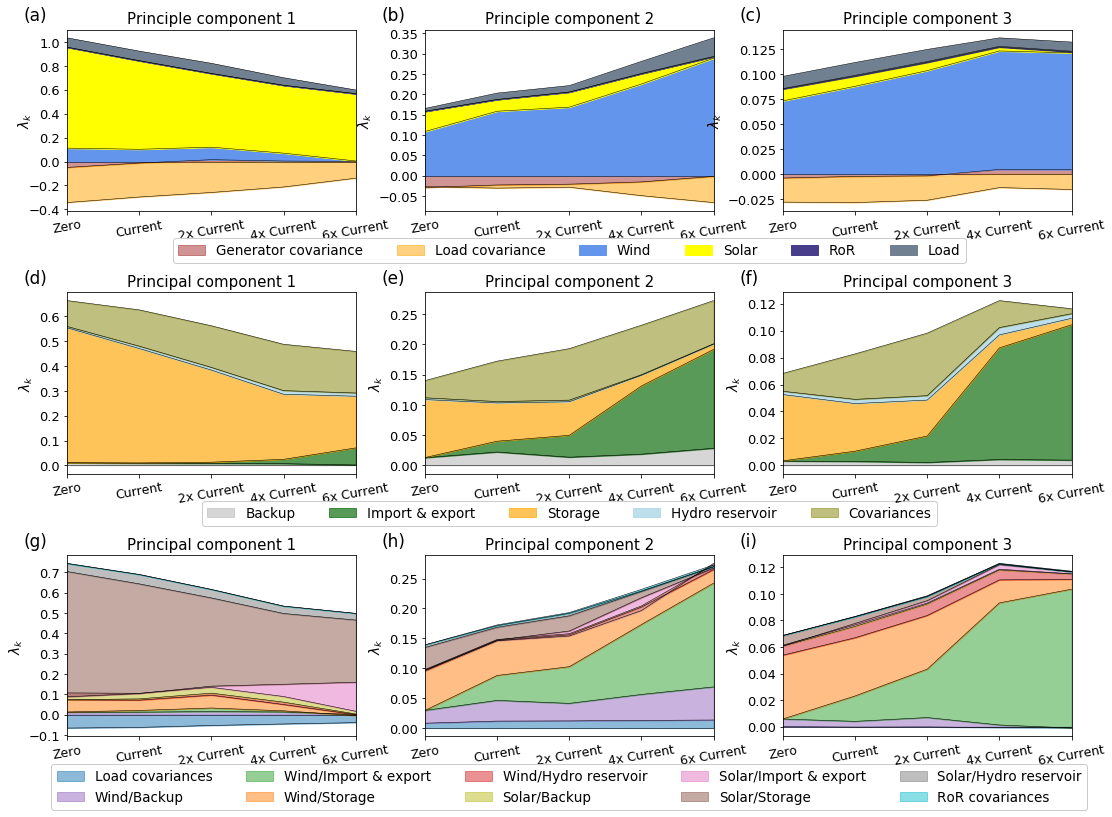

In [20]:
fig = plt.figure(figsize=(18,13))
fs = 13
panels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

for i in [0,1,2]:
    wind_con2_data  = PC_con2[i][:,:1].sum(axis=1)
    solar_con2_data = PC_con2[i][:,:2].sum(axis=1)
    hydro_con2_data = PC_con2[i][:,:3].sum(axis=1)
    load_con2_data  = PC_con2[i][:,:4].sum(axis=1)
    gen_cov_data   = PC_con2[i][:,4:7].sum(axis=1)
    load_cov_data  = PC_con2[i][:,7:10].sum(axis=1)+gen_cov_data
    # plot function
    plt.subplot(3,3,i+1)
    # Plot lines
    plt.plot(np.zeros(5),color='k',alpha=1,linewidth=0.5)
    plt.plot(wind_con2_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(solar_con2_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(hydro_con2_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(load_con2_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(gen_cov_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(load_cov_data,color='k',alpha=1,linewidth=0.5)
    # Plot fill inbetween lines
    plt.fill_between(range(5), np.zeros(5), gen_cov_data,
                     label='Generator covariance',
                     color='brown',
                     alpha=0.5)
    plt.fill_between(range(5), np.where(gen_cov_data>0, 0, gen_cov_data), load_cov_data,
                     label='Load covariance',
                     color='orange',
                     alpha=0.5, zorder=2)
    plt.fill_between(range(5), np.where(gen_cov_data<0, 0, gen_cov_data), wind_con2_data,
                     label='Wind',
                     color='cornflowerblue') # Because it is a beutiful color
    plt.fill_between(range(5), wind_con2_data, solar_con2_data,
                     label='Solar',
                     color='yellow')
    plt.fill_between(range(5), solar_con2_data, hydro_con2_data,
                     label='RoR',
                     color='darkslateblue')
    plt.fill_between(range(5), hydro_con2_data, load_con2_data,
                     label='Load',
                     color='slategray')
    if i==0:
        plt.ylabel('$\lambda_k$', fontsize=fs+0.5, labelpad=-5)
    else:
        plt.ylabel('$\lambda_k$', fontsize=fs+0.5)
    plt.xticks(np.arange(0,5),['Zero', 'Current', '2x Current', '4x Current', '6x Current'], fontsize=fs-0.5, rotation=10)
    plt.xlim((0,4))
    plt.yticks(fontsize=fs)
    plt.title('Principle component '+str(i+1), fontdict={'fontsize':fs+2})
    if i == 1:
        plt.legend(loc='center', bbox_to_anchor=(0.5,-0.22), ncol=6, fontsize=fs+0.5, framealpha=1, columnspacing=2.5)
    plt.text(-0.15, 1.05, panels[i], fontsize=fs+4, transform=plt.gca().transAxes);

for i in [0,1,2]:
    backup_con1_data        = PC_con1[i][:,:1].sum(axis=1)
    inport_export_con1_con1_data = PC_con1[i][:,:2].sum(axis=1)
    storage_con1_data       = PC_con1[i][:,:3].sum(axis=1)
    hydro_reservoir_data    = PC_con1[i][:,:4].sum(axis=1)
    backup_inport_cov_data  = PC_con1[i][:,:5].sum(axis=1)
    backup_store_cov_data   = PC_con1[i][:,:6].sum(axis=1)
    backup_hydro_reservoir_data  = PC_con1[i][:,:7].sum(axis=1)
    inport_store_cov_data        = PC_con1[i][:,:8].sum(axis=1)
    inport_hydro_reservoir_data  = PC_con1[i][:,:9].sum(axis=1)
    storage_hydro_reservoir_data = PC_con1[i][:,:10].sum(axis=1)
    # plot function
    plt.subplot(3,3,i+1+3)
    plt.plot(np.zeros(5),color='k',alpha=1,linewidth=0.5)
    plt.plot(backup_con1_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(inport_export_con1_con1_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(storage_con1_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(hydro_reservoir_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(storage_hydro_reservoir_data,color='k',alpha=1,linewidth=0.5)
    # Plot fill inbetween lines
    plt.fill_between(range(5), np.zeros(5), backup_con1_data,
                     label='Backup',
                     color='silver', alpha=0.65)
    plt.fill_between(range(5), backup_con1_data, inport_export_con1_con1_data,
                     label='Import & export',
                     color='darkgreen', alpha=0.65)
    plt.fill_between(range(5), inport_export_con1_con1_data, storage_con1_data,
                     label='Storage',
                     color='orange', alpha=0.65)
    plt.fill_between(range(5), storage_con1_data, hydro_reservoir_data,
                     label='Hydro reservoir',
                     color='lightblue', alpha=0.8)
    plt.fill_between(range(5), hydro_reservoir_data, storage_hydro_reservoir_data,
                     label='Covariances',
                     color='olive', alpha=0.5)
    plt.ylabel('$\lambda_k$', fontdict={'fontsize':fs+0.5})
    plt.xticks(np.arange(0,5),['Zero', 'Current', '2x Current', '4x Current', '6x Current'], fontsize=fs-0.5, rotation=10)
    plt.xlim((0,4))
    plt.yticks(fontsize=fs)
    plt.title('Principal component '+str(i+1), fontdict={'fontsize':fs+2})
    if i == 1:
        plt.legend(loc='center', bbox_to_anchor=(0.5,-0.22), ncol=5, fontsize=fs+0.5, framealpha=1, columnspacing=2.5)
    plt.text(-0.15, 1.05, panels[i+3], fontsize=fs+4, transform=plt.gca().transAxes);

color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown',
         'tab:pink','tab:gray','tab:olive','tab:cyan','darkblue','tan',
         'darkgreen','brown','fuchsia','yellow','purple','black',
         'olivedrab','teal','gainsboro']
for i in [0,1,2]:
    lambda_load_cov  = PC_con3[i][:,9]
    lambda_load_cov_pos  = np.where(lambda_load_cov<0, 0, lambda_load_cov)
    lambda_WB        = PC_con3[i][:,:1].sum(axis=1) +lambda_load_cov_pos
    lambda_WP        = PC_con3[i][:,:2].sum(axis=1) +lambda_load_cov_pos
    lambda_WSt       = PC_con3[i][:,:3].sum(axis=1) +lambda_load_cov_pos
    lambda_WHr       = PC_con3[i][:,:4].sum(axis=1) +lambda_load_cov_pos
    lambda_SB     = PC_con3[i][:,:5].sum(axis=1) +lambda_load_cov_pos
    lambda_SP     = PC_con3[i][:,:6].sum(axis=1) +lambda_load_cov_pos
    lambda_SSt    = PC_con3[i][:,:7].sum(axis=1) +lambda_load_cov_pos
    lambda_SHr    = PC_con3[i][:,:8].sum(axis=1) +lambda_load_cov_pos
    lambda_ror_cov   = PC_con3[i][:,:9].sum(axis=1) +lambda_load_cov_pos
    # plot function
    plt.subplot(3,3,i+1+6)
    # Plot lines
    plt.plot(np.zeros(5),color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_WB,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_WP,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_WSt,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_WHr,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_SB,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_SP,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_SSt,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_SHr,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_ror_cov,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_load_cov,color='k',alpha=1,linewidth=0.5)
    # Plot fill inbetween lines
    plt.fill_between(range(5), np.zeros(5), lambda_load_cov,
                     label='Load covariances',
                     color=color[0], alpha=0.5)
    plt.fill_between(range(5), lambda_load_cov_pos, lambda_WB,
                     label='Wind/Backup',
                     color=color[4], alpha=0.5)
    plt.fill_between(range(5), lambda_WB, lambda_WP,
                     label='Wind/Import & export',
                     color=color[2], alpha=0.5)
    plt.fill_between(range(5), lambda_WP, lambda_WSt,
                     label='Wind/Storage',
                     color=color[1], alpha=0.5)
    plt.fill_between(range(5), lambda_WSt, lambda_WHr,
                     label='Wind/Hydro reservoir',
                     color=color[3], alpha=0.5)
    plt.fill_between(range(5), lambda_WHr, lambda_SB,
                     label='Solar/Backup',
                     color=color[8], alpha=0.5)
    plt.fill_between(range(5), lambda_SB, lambda_SP,
                     label='Solar/Import & export',
                     color=color[6], alpha=0.5)
    plt.fill_between(range(5), lambda_SP, lambda_SSt,
                     label='Solar/Storage',
                     color=color[5], alpha=0.5)
    plt.fill_between(range(5), lambda_SSt, lambda_SHr,
                     label='Solar/Hydro reservoir',
                     color=color[7], alpha=0.5)
    plt.fill_between(range(5), lambda_SHr, lambda_ror_cov, 
                     label='RoR covariances',
                     color=color[9], alpha=0.5)
    plt.ylabel('$\lambda_k$', fontdict={'fontsize':fs+0.5})
    plt.xticks(np.arange(0,5),['Zero', 'Current', '2x Current', '4x Current', '6x Current'], fontsize=fs-0.5, rotation=10)
    plt.xlim((0,4))
    plt.yticks(fontsize=fs)
    plt.title('Principal component '+str(i+1), fontdict={'fontsize':fs+2})
    if i == 1:
        plt.legend(loc='center', bbox_to_anchor=(0.5,-0.28), ncol=5, fontsize=fs+0.5, framealpha=1, columnspacing=2.5)
    plt.text(-0.15, 1.05, panels[i+6], fontsize=fs+4, transform=plt.gca().transAxes);
    
plt.subplots_adjust(hspace=0.45, wspace=0.24)

## Plot by CO$_2$ emission reduction

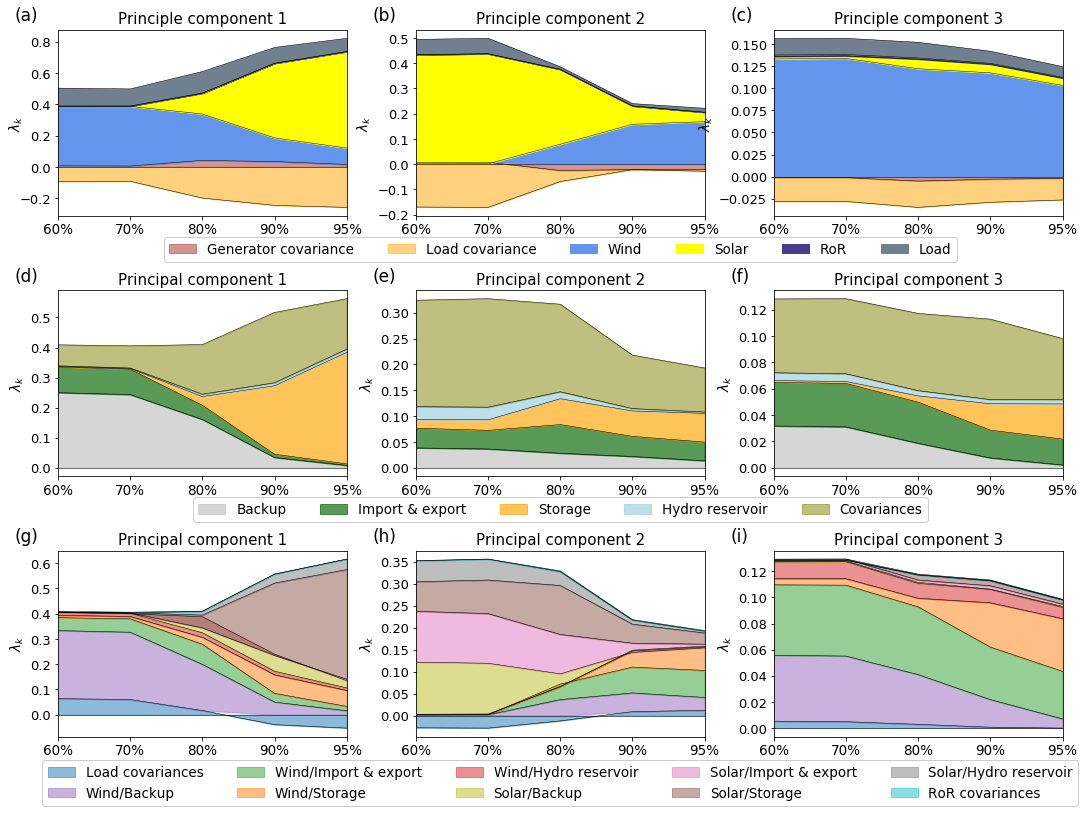

In [44]:
fig = plt.figure(figsize=(18,13))
fs = 13
panels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

for i in [0,1,2]:
    wind_con2_data  = PC_conCo2_1[i][:,:1].sum(axis=1)
    solar_con2_data = PC_conCo2_1[i][:,:2].sum(axis=1)
    hydro_con2_data = PC_conCo2_1[i][:,:3].sum(axis=1)
    load_con2_data  = PC_conCo2_1[i][:,:4].sum(axis=1)
    gen_cov_data   = PC_conCo2_1[i][:,4:7].sum(axis=1)
    load_cov_data  = PC_conCo2_1[i][:,7:10].sum(axis=1) +gen_cov_data
    # plot function
    plt.subplot(3,3,i+1)
    plt.plot(np.zeros(5),color='k',alpha=1,linewidth=0.5)
    plt.plot(wind_con2_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(solar_con2_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(hydro_con2_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(load_con2_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(gen_cov_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(load_cov_data,color='k',alpha=1,linewidth=0.5)
    # Plot fill inbetween lines
    plt.fill_between(range(5), np.zeros(5), gen_cov_data,
                     label='Generator covariance',
                     color='brown',
                     alpha=0.5)
    plt.fill_between(range(5), np.where(gen_cov_data>0, 0, gen_cov_data), load_cov_data,
                     label='Load covariance',
                     color='orange',
                     alpha=0.5, zorder=2)
    plt.fill_between(range(5), np.where(gen_cov_data<0, 0, gen_cov_data), wind_con2_data,
                     label='Wind',
                     color='cornflowerblue') # Because it is a beutiful color
    plt.fill_between(range(5), wind_con2_data, solar_con2_data,
                     label='Solar',
                     color='yellow')
    plt.fill_between(range(5), solar_con2_data, hydro_con2_data,
                     label='RoR',
                     color='darkslateblue')
    plt.fill_between(range(5), hydro_con2_data, load_con2_data,
                     label='Load',
                     color='slategray')
    if i==0:
        plt.ylabel('$\lambda_k$', fontsize=fs+0.5, labelpad=-5)
    else:
        plt.ylabel('$\lambda_k$', fontsize=fs+0.5)
    plt.xticks(np.arange(0,5),['60%', '70%', '80%', '90%', '95%'], fontsize=fs+0.5)
    plt.xlim((0,4))
    plt.yticks(fontsize=fs)
    plt.title('Principle component '+str(i+1), fontdict={'fontsize':fs+2})
    if i == 1:
        plt.legend(loc='center', bbox_to_anchor=(0.5,-0.18), ncol=6, fontsize=fs+0.5, framealpha=1, columnspacing=2.5)
    plt.text(-0.15, 1.05, panels[i], fontsize=fs+4, transform=plt.gca().transAxes);

for i in [0,1,2]:
    backup_con1_data        = PC_conCo2_2[i][:,:1].sum(axis=1)
    inport_export_con1_con1_data = PC_conCo2_2[i][:,:2].sum(axis=1)
    storage_con1_data       = PC_conCo2_2[i][:,:3].sum(axis=1)
    hydro_reservoir_data    = PC_conCo2_2[i][:,:4].sum(axis=1)
    backup_inport_cov_data  = PC_conCo2_2[i][:,:5].sum(axis=1)
    backup_store_cov_data   = PC_conCo2_2[i][:,:6].sum(axis=1)
    backup_hydro_reservoir_data  = PC_conCo2_2[i][:,:7].sum(axis=1)
    inport_store_cov_data        = PC_conCo2_2[i][:,:8].sum(axis=1)
    inport_hydro_reservoir_data  = PC_conCo2_2[i][:,:9].sum(axis=1)
    storage_hydro_reservoir_data = PC_conCo2_2[i][:,:10].sum(axis=1)
    # plot function
    plt.subplot(3,3,i+1+3)
    plt.plot(np.zeros(5),color='k',alpha=1,linewidth=0.5)
    plt.plot(backup_con1_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(inport_export_con1_con1_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(storage_con1_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(hydro_reservoir_data,color='k',alpha=1,linewidth=0.5)
    plt.plot(storage_hydro_reservoir_data,color='k',alpha=1,linewidth=0.5)
    # Plot fill inbetween lines
    plt.fill_between(range(5), np.zeros(5), backup_con1_data,
                     label='Backup',
                     color='silver', alpha=0.65)
    plt.fill_between(range(5), backup_con1_data, inport_export_con1_con1_data,
                     label='Import & export',
                     color='darkgreen', alpha=0.65)
    plt.fill_between(range(5), inport_export_con1_con1_data, storage_con1_data,
                     label='Storage',
                     color='orange', alpha=0.65)
    plt.fill_between(range(5), storage_con1_data, hydro_reservoir_data,
                     label='Hydro reservoir',
                     color='lightblue', alpha=0.8)
    plt.fill_between(range(5), hydro_reservoir_data, storage_hydro_reservoir_data,
                     label='Covariances',
                     color='olive', alpha=0.5)
    plt.ylabel('$\lambda_k$', fontdict={'fontsize':fs+0.5})
    plt.xticks(np.arange(0,5),['60%', '70%', '80%', '90%', '95%'], fontsize=fs+0.5)
    plt.xlim((0,4))
    plt.yticks(fontsize=fs)
    plt.title('Principal component '+str(i+1), fontdict={'fontsize':fs+2})
    if i == 1:
        plt.legend(loc='center', bbox_to_anchor=(0.5,-0.18), ncol=5, fontsize=fs+0.5, framealpha=1, columnspacing=2.5)
    plt.text(-0.15, 1.05, panels[i+3], fontsize=fs+4, transform=plt.gca().transAxes);

color = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown',
         'tab:pink','tab:gray','tab:olive','tab:cyan','darkblue','tan',
         'darkgreen','brown','fuchsia','yellow','purple','black',
         'olivedrab','teal','gainsboro']
for i in [0,1,2]:
    lambda_load_cov  = PC_conCo2_3[i][:,9]
    lambda_load_cov_pos  = np.where(lambda_load_cov<0, 0, lambda_load_cov)
    lambda_WB        = PC_conCo2_3[i][:,:1].sum(axis=1) +lambda_load_cov_pos
    lambda_WP        = PC_conCo2_3[i][:,:2].sum(axis=1) +lambda_load_cov_pos
    lambda_WSt       = PC_conCo2_3[i][:,:3].sum(axis=1) +lambda_load_cov_pos
    lambda_WHr       = PC_conCo2_3[i][:,:4].sum(axis=1) +lambda_load_cov_pos
    lambda_SB     = PC_conCo2_3[i][:,:5].sum(axis=1) +lambda_load_cov_pos
    lambda_SP     = PC_conCo2_3[i][:,:6].sum(axis=1) +lambda_load_cov_pos
    lambda_SSt    = PC_conCo2_3[i][:,:7].sum(axis=1) +lambda_load_cov_pos
    lambda_SHr    = PC_conCo2_3[i][:,:8].sum(axis=1) +lambda_load_cov_pos
    lambda_ror_cov   = PC_conCo2_3[i][:,:9].sum(axis=1) +lambda_load_cov_pos
    # plot function
    plt.subplot(3,3,i+1+6)
    plt.plot(np.zeros(5),color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_WB,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_WP,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_WSt,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_WHr,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_SB,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_SP,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_SSt,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_SHr,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_ror_cov,color='k',alpha=1,linewidth=0.5)
    plt.plot(lambda_load_cov,color='k',alpha=1,linewidth=0.5)
    # Plot fill inbetween lines
    plt.fill_between(range(5), np.zeros(5), lambda_load_cov, 
                     label='Load covariances',
                     color=color[0], alpha=0.5)
    plt.fill_between(range(5), lambda_load_cov_pos, lambda_WB,
                     label='Wind/Backup',
                     color=color[4], alpha=0.5)
    plt.fill_between(range(5), lambda_WB, lambda_WP,
                     label='Wind/Import & export',
                     color=color[2], alpha=0.5)
    plt.fill_between(range(5), lambda_WP, lambda_WSt,
                     label='Wind/Storage',
                     color=color[1], alpha=0.5)
    plt.fill_between(range(5), lambda_WSt, lambda_WHr,
                     label='Wind/Hydro reservoir',
                     color=color[3], alpha=0.5)
    plt.fill_between(range(5), lambda_WHr, lambda_SB,
                     label='Solar/Backup',
                     color=color[8], alpha=0.5)
    plt.fill_between(range(5), lambda_SB, lambda_SP,
                     label='Solar/Import & export',
                     color=color[6], alpha=0.5)
    plt.fill_between(range(5), lambda_SP, lambda_SSt,
                     label='Solar/Storage',
                     color=color[5], alpha=0.5)
    plt.fill_between(range(5), lambda_SSt, lambda_SHr,
                     label='Solar/Hydro reservoir',
                     color=color[7], alpha=0.5)
    plt.fill_between(range(5), lambda_SHr, lambda_ror_cov,
                     label='RoR covariances',
                     color=color[9], alpha=0.5)
    plt.ylabel('$\lambda_k$', fontdict={'fontsize':fs+0.5})
    plt.xticks(np.arange(0,5),['60%', '70%', '80%', '90%', '95%'], fontsize=fs+0.5)
    plt.xlim((0,4))
    plt.yticks(fontsize=fs)
    plt.title('Principal component '+str(i+1), fontdict={'fontsize':fs+2})
    if i == 1:
        plt.legend(loc='center', bbox_to_anchor=(0.5,-0.25), ncol=5, fontsize=fs+0.5, framealpha=1, columnspacing=2.5)
    plt.text(-0.15, 1.05, panels[i+6], fontsize=fs+4, transform=plt.gca().transAxes);

plt.subplots_adjust(hspace=0.4, wspace=0.24)